# 지하철 노선 경로 네트워크
**201823871 박지헌**
## 0. Settings

In [3]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap as Basemap
import matplotlib.lines as mlines
import warnings; warnings.simplefilter('ignore')

In [4]:
pd.set_option("max_rows", 5)
pd.set_option("max_columns", None)

In [6]:
# '역' & '(###)'지우기
def stationNameClear(stations):
    station_list = []
    for station in stations['역사명']:
        if station[-1] == ')':        
            station = ''.join(station.split('(')[:-1])
        if station[-1] == '역':
            station = station[:-1]
        station_list.append(station)
        
    stations['역사명']=station_list
    return stations

# 띄어쓰기 제거
def spaceClear(stations):
    station_list = []
    for station in stations['영문역사명']:
        station_list.append(station.replace(" ",""))

    stations['영문역사명']=station_list
    return stations

# 2열 데이터 프레임을 딕셔너리로
def df2dict(df):
    if df.shape[1] != 2 :
        return print('only 2 columns')
    
    df_dict = {}
    for key, value in zip(df.iloc[:, 0], df.iloc[:, 1]):
        df_dict[key] = value
        
    return df_dict

## 1. StationDf for 지리적 정보

In [7]:
stations = pd.read_csv('data/input/전국도시철도역사정보표준데이터.csv')
stationNameClear(stations)
spaceClear(stations)
stations

,역번호,역사명,노선번호,노선명,영문역사명,한자역사명,환승역구분,환승노선번호,환승노선명,역위도,역경도,운영기관명,역사도로명주소,역사전화번호,데이터기준일자,제공기관코드,제공기관명
0,3122,부평삼거리,S2801,인천지하철 1호선,Bupyeongsamgeori,富平三거리,일반역,-,-,37.478267,126.710494,인천교통공사,인천광역시 부평구 경인로 765,032-516-3122,2020-11-30,B551894,인천교통공사
1,3123,간석오거리,S2801,인천지하철 1호선,Ganseogogeori,間石五거리,일반역,-,-,37.466921,126.707861,인천교통공사,인천광역시 남동구 경인로 674,032-434-3123,2020-11-30,B551894,인천교통공사
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1013,4137,둔촌오륜,S1109,서울 도시철도 9호선,DunchonOryun,遁村五輪,일반역,NaN,NaN,37.517975,127.140170,서울교통공사,서울특별시 송파구 강동대로 327,02-2656-0937,2021-04-09,B553766,서울교통공사
1014,4138,중앙보훈병원,S1109,서울 도시철도 9호선,VHSMedicalCenter,中央報?病院,일반역,NaN,NaN,37.529614,127.142757,서울교통공사,서울특별시 강동구 명일로 117,02-2656-0938,2021-04-09,B553766,서울교통공사


In [9]:
stationDf=stations[['역사명','영문역사명','역위도','역경도']]
stationDf.rename(columns={'역사명':'kor_name','영문역사명':'eng_name','역위도':'latitude','역경도':'longitude'},inplace=True)
metroKorEngDict=df2dict(stationDf[['kor_name','eng_name']])
stationDf

,kor_name,eng_name,latitude,longitude
0,부평삼거리,Bupyeongsamgeori,37.478267,126.710494
1,간석오거리,Ganseogogeori,37.466921,126.707861
...,...,...,...,...
1013,둔촌오륜,DunchonOryun,37.517975,127.140170
1014,중앙보훈병원,VHSMedicalCenter,37.529614,127.142757


In [10]:
stationName_ix = stationDf['eng_name'].values
stationName_ix

array(['Bupyeongsamgeori', 'Ganseogogeori', 'IncheonCityHall', ...,
       'OlympicPark', 'DunchonOryun', 'VHSMedicalCenter'], dtype=object)

## 2. SubwayDf for 노선 정보

In [12]:
subway = pd.read_csv('data/input/subway.csv')
subway

,from,to,line
0,소요산,동두천,1
1,동두천,보산,1
...,...,...,...
694,초지,원곡,서해선
695,원곡,원시,서해선


In [13]:
subway['from'] = subway['from'].map(metroKorEngDict)
subway['to'] = subway['to'].map(metroKorEngDict)
subway.dropna(inplace=True)
subway

,from,to,line
0,Soyosan,Dongducheon,1
1,Dongducheon,Bosan,1
...,...,...,...
683,SungshinWomen`sUniv.,Bomun,우이신설
684,Bomun,Sinseol-dong,우이신설


In [14]:
subway = subway[(subway['from'].isin(stationName_ix)) & (subway['to'].isin(stationName_ix))]
subwayDf = subway[['from','to']]
subwayDf

,from,to
0,Soyosan,Dongducheon
1,Dongducheon,Bosan
...,...,...
683,SungshinWomen`sUniv.,Bomun
684,Bomun,Sinseol-dong


In [15]:
subwayDf =  pd.DataFrame(subwayDf.groupby(['from', 'to']).size().reset_index(name='counts'))
subwayDf

,from,to,counts
0,Achasan,Gwangnaru,1
1,Aeogae,Chungjeongno,1
...,...,...,...
602,Yongsan,Ichon,1
603,Yongsan,Noryangjin,1


## 3. Counts

In [16]:
counts = subwayDf['from'].append(subwayDf.loc[subwayDf['from'] != subwayDf['to'], 'to']).value_counts()
counts = pd.DataFrame({'eng_name': counts.index, 'total': counts})
counts

,eng_name,total
Wangsimni,Wangsimni,7
Jongno3(sam)-ga,Jongno3(sam)-ga,6
...,...,...
Gangdong-guOffice,Gangdong-guOffice,1
EwhaWomansUniv.,EwhaWomansUniv.,1


## 4. Pos_data

In [17]:
pos_data = counts.merge(stationDf, on = 'eng_name')
pos_data

,eng_name,total,kor_name,latitude,longitude
0,Wangsimni,7,왕십리,37.561525,127.037508
1,Wangsimni,7,왕십리,37.561128,127.035505
...,...,...,...,...,...
652,Gangdong-guOffice,1,강동구청,37.530471,127.120269
653,EwhaWomansUniv.,1,이대,37.556721,126.945801


## 5. 시각화

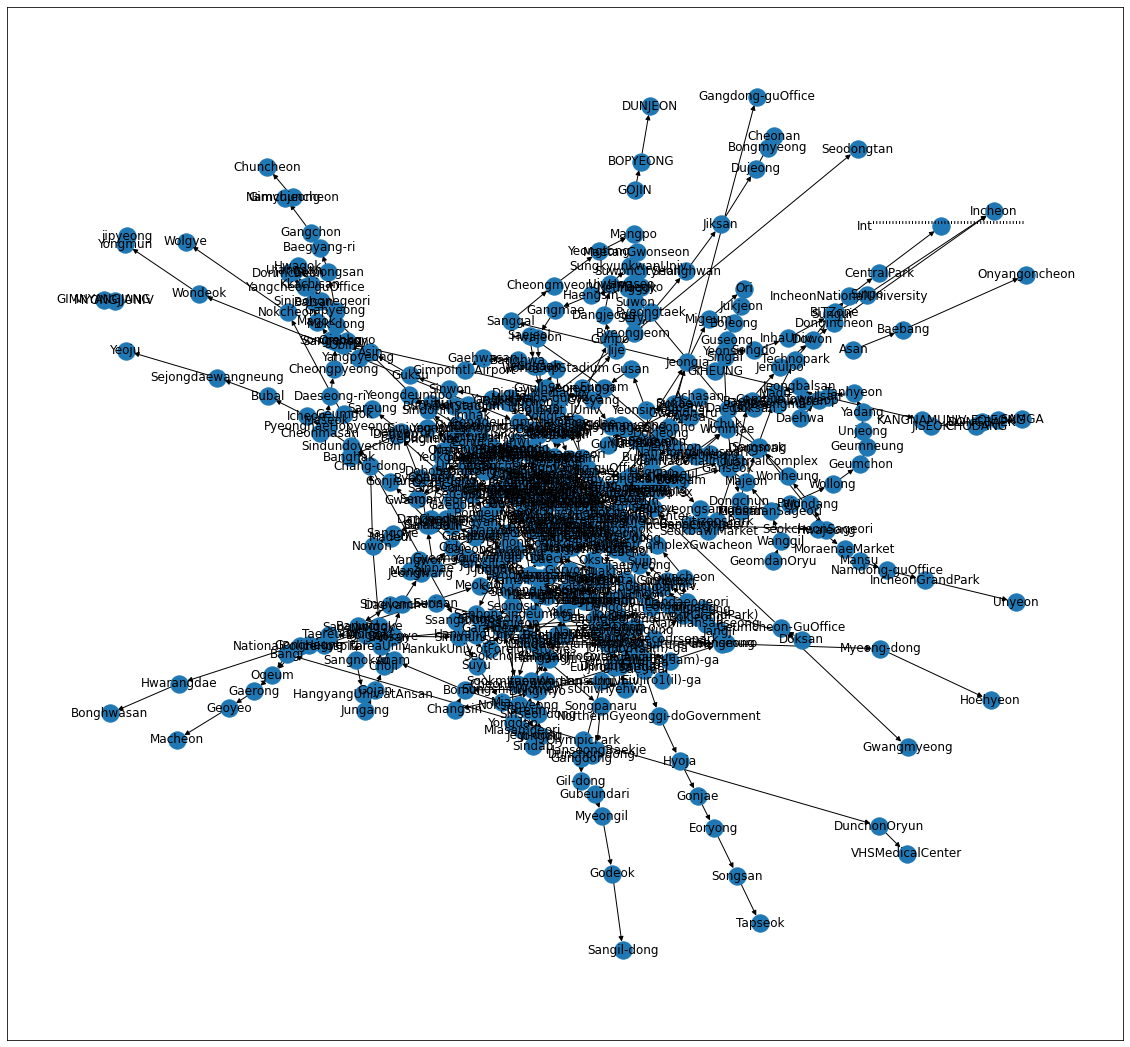

In [18]:
graph = nx.from_pandas_edgelist(
    subwayDf,
    source = 'from',
    target = 'to',
    edge_attr = 'counts',
    create_using = nx.DiGraph())

plt.figure(figsize = (20,19))
nx.draw_networkx(graph)

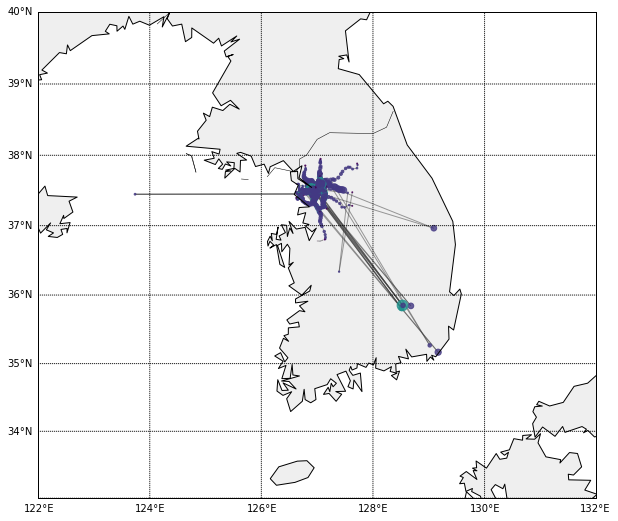

In [32]:
plt.figure(figsize=(10,10))
m = Basemap(
    projection='merc',
    llcrnrlon=122,
    llcrnrlat=33,
    urcrnrlon=132,
    urcrnrlat=40,
    lat_ts=0,
    resolution='l',
    suppress_ticks=True)

# import long lat as m attribute
mx, my = m(pos_data['longitude'].values, pos_data['latitude'].values)
pos = {}
for count, elem in enumerate (pos_data['eng_name']):
    pos[elem] = (mx[count], my[count])
betCent = nx.betweenness_centrality(graph, normalized=True, endpoints=True)
node_color = [20000.0 * graph.degree(v) for v in graph]
node_size =  [v * 1000 for v in betCent.values()]

# #draw nodes and edges and over aly on basemap
# # nodes
nx.draw_networkx_nodes(
    G = graph,
    pos = pos,
    nodelist = graph.nodes(),
    node_color = node_color,
    alpha = 0.8,
    node_size = node_size)

# edges
nx.draw_networkx_edges(
    G = graph,
    pos = pos,
    width = subwayDf['counts']*1,
    alpha=0.5,
    arrows = False)

m.drawcoastlines()
m.drawcountries()
m.drawmapboundary()
m.fillcontinents(alpha = 0.3)

# lat/lon setting
parallels = np.arange(30.,50.,1.)
m.drawparallels(parallels,labels=[True,False,False,False])
meridians = np.arange(120.,150.,2.)
m.drawmeridians(meridians,labels=[True,False,False,True])

plt.show()

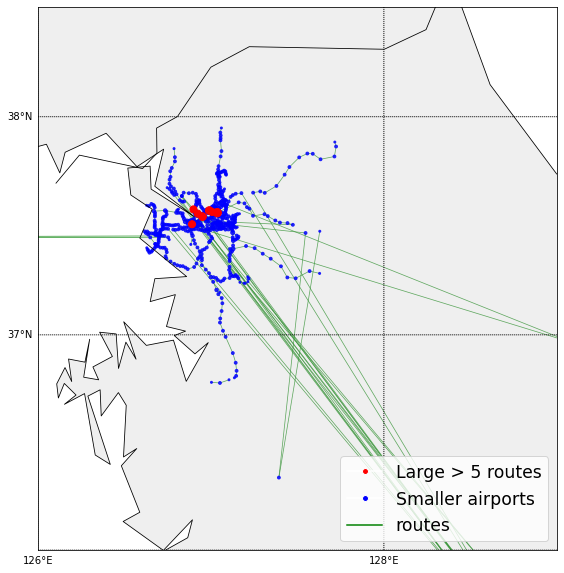

In [30]:
plt.figure(figsize = (10,10))
m = Basemap(
    projection='merc',
    llcrnrlon=126,
    llcrnrlat=36,
    urcrnrlon=129,
    urcrnrlat=38.5,
    lat_ts=0,
    resolution='l',
    suppress_ticks=True)

mx, my = m(pos_data['longitude'].values, pos_data['latitude'].values)
pos = {}
for count, elem in enumerate (pos_data['eng_name']):
    pos[elem] = (mx[count], my[count])

# 100이하 노드
nx.draw_networkx_nodes(
    G = graph,
    pos = pos,
    nodelist = [x for x in graph.nodes() if counts['total'][x] < 5],
    node_color = 'b',
    alpha = 0.8,
    node_size = [counts['total'][x]*4  for x in graph.nodes() if counts['total'][x] < 5])
# 100이상 nodes
nx.draw_networkx_nodes(
    G = graph,
    pos = pos,
    nodelist = [x for x in graph.nodes() if counts['total'][x] >= 5],
    node_color = 'r',
    alpha = 1,
    node_size = [counts['total'][x]*10  for x in graph.nodes() if counts['total'][x] >= 5])

nx.draw_networkx_edges(
    G = graph,
    pos = pos,
    edge_color = 'g',
    width = subwayDf['counts']*0.75, 
    alpha=0.8,
    arrows = False)

m.drawcountries(linewidth = 0.8)
m.drawstates(linewidth = 0.2)
m.drawcoastlines(linewidth = 0.8)
m.fillcontinents(alpha = 0.3)
# lat/lon setting
parallels = np.arange(30.,50.,1.)
m.drawparallels(parallels,labels=[True,False,False,False])
meridians = np.arange(120.,150.,2.)
m.drawmeridians(meridians,labels=[True,False,False,True])

line1 = mlines.Line2D(range(1), range(1), color="white", marker='o', markerfacecolor="red")
line2 = mlines.Line2D(range(1), range(1), color="white", marker='o',markerfacecolor="blue")
line3 = mlines.Line2D(range(1), range(1), color="green", marker='',markerfacecolor="green")
plt.legend((line1, line2, line3), ('Large > 5 routes', 'Smaller airports', 'routes'), loc=4, fontsize = 'xx-large')
plt.show()